# Optimizing Public Health Systems using Voronoi Diagrams and Unsupervised ML

## Abstract

This study explores the application of Voronoi diagrams in modeling and optimizing access to public health facilities. It starts with a basic model that maps population distribution across a geographic area using points and Voronoi cells, providing findings into facility load distribution and imbalances. To address the complexities of real-world scenarios, the research then introduces an improved scoring system that incorporates factors such as population density, patient decision-making, and health-related risks to create a more nuanced evaluation of facility performance and accessibility.

Dynamic optimization algorithms, including weighted k-means clustering and iterative adjustments, are developed to optimize key factors, such as minimizing variance in population distribution across facilities and reducing the number of individuals located far from these facilities. Using real-world data from Atlanta, Georgia, the study demonstrates the practical applicability of these approaches in identifying and potentially mitigating disparities in facility access. The research also features Python-based implementations using Matplotlib, with the raw code included as a resource for further development. Finally, preliminary explorations of alternative algorithms and ideas are presented, focusing on improving population balancing mechanisms and introducing ”forces” to optimize facility locations.

## Implementation

Here we introduce examples of how our algorithms and strategies are implemented. These are slightly different from those in the .py files, so I would recommend looking at both sources. To run the Python scripts in this project, simply have Python installed, and run:

```console
python filename.py
```

Let's start by implementing an initial model that sums up the population in each Voronoi cell, along the way writing the code to draw a color-mapped Voronoi diagram.

### Initial Model

We import the necessary Python libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, Delaunay, voronoi_plot_2d
import random

We implement a sample dataset of initial facility points (source points) and population-position points

In [2]:
# creating sample datasets

source_points = np.array([[1, 1], [6, 10], [25, 2], [15, 23], [6, 7]], dtype='float64')
# create python list and then convert to Numpy array
pop_list = []

# create sample grid of population points
for i in range(0, 35, 5):
    for j in range(0, 35, 5):
        #random population value
        pop_list.append([i, j, random.randint(1, 35)])

pop_points = np.array(pop_list)

np.set_printoptions(threshold=5)
print(f"Source points (# of elements={len(source_points)}): {source_points}")
print(f"Population points (# of elements={len(pop_points)}): {pop_points}")

Source points (# of elements=5): [[ 1.  1.]
 [ 6. 10.]
 [25.  2.]
 [15. 23.]
 [ 6.  7.]]
Population points (# of elements=49): [[ 0  0 17]
 [ 0  5  4]
 [ 0 10  8]
 ...
 [30 20 12]
 [30 25 24]
 [30 30 21]]


Now, we implement the code utilizing SciPy and Matplotlib to draw the Voronoi diagram.

(0.0, 30.5)

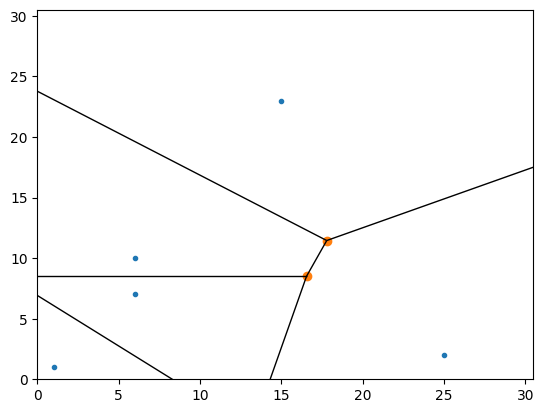

In [3]:
# add distant ghost points to source points for purposes of drawing complete Voronoi diagram
upd_source_points = np.append(source_points,  [[9999,9999], [-9999,9999], [9999,-9999], [-9999,-9999]], axis = 0)

# set graph bounds
bounding_box = np.array([0., 30.5, 0., 30.5]) #x_min, x_max, y_min, y_max

# compute voronoi areas
vor = Voronoi(upd_source_points)

# create matplotlib graph
fig, ax = plt.subplots()

voronoi_plot_2d(vor, ax=ax)

# apply bounds to graph
ax.set_xlim(bounding_box[0], bounding_box[1])
ax.set_ylim(bounding_box[2], bounding_box[3])

We implement a function to compute the population in each cell. A population belongs to the cell of the closest source point (or as we'll also use interchangeably, facility).

In [4]:
def computePopulation(pop_points, source_points):
    # initial population counts for each source point (start at 0)
    source_point_pops = np.array(np.zeros(len(source_points)), dtype=np.int16)
    for i in range(0, len(pop_points)):
        # get population point position
        p_x = pop_points[i, 0]
        p_y = pop_points[i, 1]

        # save current minimum distance and index
        min_dist = 1e12
        min_index = -1
        
        for j in range(0, len(source_points)):
            # get facility position
            source_x = source_points[j, 0]
            source_y = source_points[j, 1]

            # calculate distance and save new distance + facility if smaller
            dist = (source_x - p_x)**2 + (source_y - p_y)**2
            if (dist < min_dist):
                min_dist = dist
                min_index = j

        # add population to facility with index of associated cell
        source_point_pops[min_index] += pop_points[i, 2]
    
    np.set_printoptions(threshold=1000)
    # print computed populations
    return source_point_pops
    
# run function to test
source_point_pops = computePopulation(pop_points, source_points)

print(source_point_pops)

[ 48 117 197 371  49]


We will now implement a function to make the graph more visual and clear. This function will color each cell based on a comparison between the population in each cell and the total average population in each cell. The function will also label each point with the current population in the cell.

In [5]:
def color_func(source_point_pops):
    # get all voronoi regions
    regions = vor.point_region

    # compute population average
    pop_avg = np.average(source_point_pops)

    # define color of cell based on ratio
    ratio_colors = {
        13: "#ffad66",
        12: "#f2dd1b",
        11: "#5ea86e",
        10: "#5ea86e",
        9: "#58db74",
        8: "#bdf0c8",
        7: "#60e06d",
    }
    
    for i in range(len(regions)):
        # get points/polygon defining each Voronoi cell
        region = vor.regions[vor.point_region[i]]
        polygon = [vor.vertices[i] for i in region]

        # determining cell color
        color = "#ffffff"
        
        if (i < len(source_points)):
            # get ratio (times 10 and rounded to get clear integer)
            ratio = round(source_point_pops[i]/pop_avg * 10)
    
            if (ratio < 7):
                color = "#11a841"
            elif (ratio > 13):
                color = "#f01b07"
            else:
                color = ratio_colors[ratio]

        #color regions
        ax.fill(*zip(*polygon), alpha=0.4, facecolor=color)

        if (i < len(source_points)):
            ax.annotate("Pop: " + str(source_point_pops[i]), (source_points[i, 0], source_points[i, 1]))
    
color_func(source_point_pops)

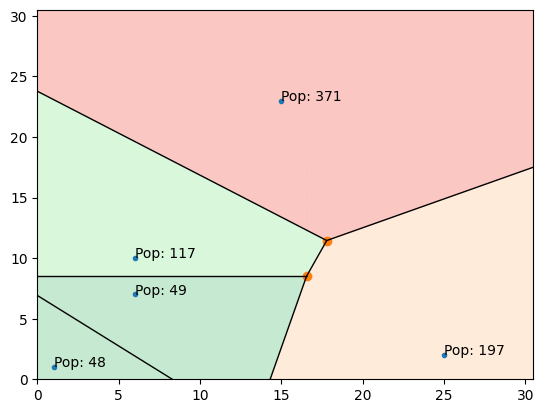

In [6]:
fig